# SEMANTIC SEGMENTATION ON SAMPLE OF CITYSPACE DATASET (Option 02)

## Importing Libraries


In [62]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Mounting the Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading the images and resizing it

In [63]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=12 #Number of classes for segmentation

path_train="/content/gdrive/MyDrive/Colab Notebooks/Assignment 03/dataset1/images_prepped_train/"

#Capture training image info as a list
train_images = []

for directory_path in glob.glob(path_train):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

path_train_mask="/content/gdrive/MyDrive/Colab Notebooks/Assignment 03/dataset1/annotations_prepped_train/"

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(path_train_mask):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [37]:
print(train_images.shape,train_masks.shape)
#print(test_images.shape,test_masks.shape)

(367, 256, 256) (367, 256, 256)


## Encoding Labels into Mask Images

In [38]:
#Encode labels
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [39]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [41]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [64]:
print(train_masks_reshaped_encoded)

[1 1 1 ... 3 3 3]


## Calculating Class Weights

In [43]:
###############################################################
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


Class weights are...: [ 0.49103854  0.35784426  8.39919932  0.26478814  1.85447001  0.85473691
  7.09864436  7.38880471  1.41907148 13.04489729 28.49985544  2.1209241 ]


In [60]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

# OPTION 02

## Architecture 01- Baseline Network U-NET

### Developing the Model

In [61]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# IMG_HEIGHT=256
# IMG_WIDTH=256

#Build the model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
s = inputs

#Downsampling
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
    
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
     
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
     
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
#Upsampling 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
model = Model(inputs=[inputs], outputs=[outputs])

### Compiling the model and defining the optimizer,loss and metrics

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 256, 256, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_28 (Dropout)           (None, 256, 256, 16  0           ['conv2d_58[0][0]']              
                                )                                                           

### Fitting the created U-NET model

In [47]:
# history = model.fit(X_train, y_train_cat, 
#                     batch_size = 16, 
#                     verbose=1, 
#                     epochs=50, 
#                     validation_data=(X_test, y_test_cat), 
#                     #class_weight=class_weights,
#                     shuffle=False
#                     )
                    


# model.save('test.hdf5')

Epoch 1/50
17/17 [==============================] - 24s 596ms/step - loss: 2.3862 - accuracy: 0.1524 - val_loss: 2.1899 - val_accuracy: 0.1998
Epoch 2/50
17/17 [==============================] - 6s 359ms/step - loss: 2.0302 - accuracy: 0.2025 - val_loss: 1.9868 - val_accuracy: 0.3192
Epoch 3/50
17/17 [==============================] - 6s 359ms/step - loss: 1.9191 - accuracy: 0.2570 - val_loss: 1.8982 - val_accuracy: 0.3656
Epoch 4/50
17/17 [==============================] - 6s 358ms/step - loss: 1.7841 - accuracy: 0.3472 - val_loss: 1.6999 - val_accuracy: 0.4638
Epoch 5/50
17/17 [==============================] - 6s 357ms/step - loss: 1.5951 - accuracy: 0.4764 - val_loss: 1.6026 - val_accuracy: 0.4702
Epoch 6/50
17/17 [==============================] - 6s 358ms/step - loss: 1.4707 - accuracy: 0.5417 - val_loss: 1.4786 - val_accuracy: 0.5389
Epoch 7/50
17/17 [==============================] - 6s 357ms/step - loss: 1.3980 - accuracy: 0.5712 - val_loss: 1.4377 - val_accuracy: 0.5543
Epoch

### Evaluating the model

#### 1. Accuracy

In [48]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

2/2 [==============================] - 3s 63ms/step - loss: 1.2194 - accuracy: 0.5744
Accuracy is =  57.440680265426636 %


#### 2. Loss and Accuracy graphs

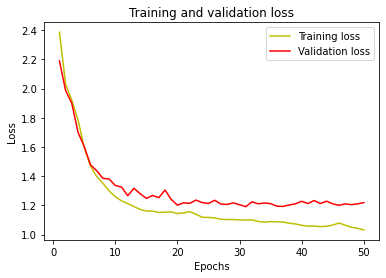

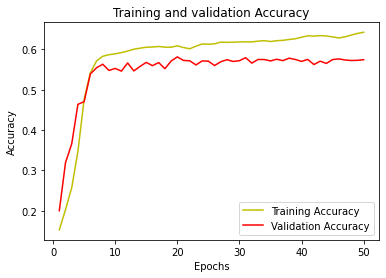

In [51]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
model.load_weights('test.hdf5')  

#### 3. Prediction on few images

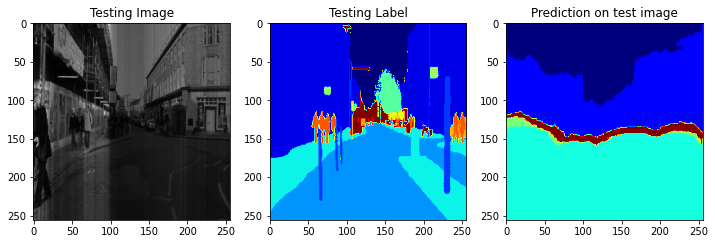

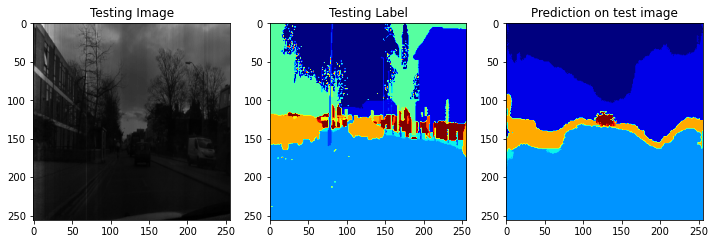

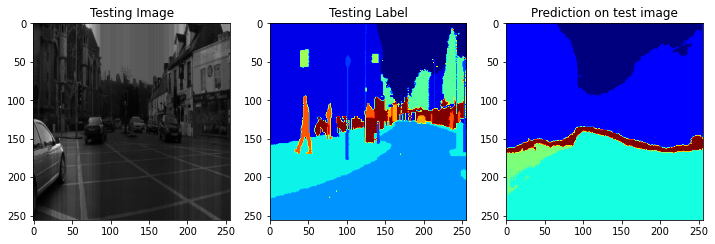

In [59]:
#Predict on a few images

import random

# No. of images to prdict 
i=[1,2,3]

for n in i:
  test_img_number = random.randint(0, len(X_test))
  test_img = X_test[test_img_number]
  ground_truth=y_test[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0], cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()